In [1034]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from sklearn import preprocessing as pre
from sklearn.metrics import r2_score
import logging

In [1035]:
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

In [1036]:
filename = open('./data/pokemon.csv')
pokemon = pd.read_csv(filename)
pokemon.head()

,name,pokedex_number,abilities,typing,hp,attack,defense,special_attack,special_defense,speed,...,ground_attack_effectiveness,fly_attack_effectiveness,psychic_attack_effectiveness,bug_attack_effectiveness,rock_attack_effectiveness,ghost_attack_effectiveness,dragon_attack_effectiveness,dark_attack_effectiveness,steel_attack_effectiveness,fairy_attack_effectiveness
0,Bulbasaur,1,Overgrow~Chlorophyll,Grass~Poison,45,49,49,65,65,45,...,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,0.5
1,Ivysaur,2,Overgrow~Chlorophyll,Grass~Poison,60,62,63,80,80,60,...,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,0.5
2,Venusaur,3,Overgrow~Chlorophyll,Grass~Poison,80,82,83,100,100,80,...,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,0.5
3,Venusaur Gmax,3,Overgrow~Chlorophyll,Grass~Poison,80,82,83,100,100,80,...,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,0.5
4,Venusaur Mega,3,Thick Fat,Grass~Poison,80,100,123,122,120,80,...,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,0.5


In [1037]:
pokemon.drop_duplicates(subset="pokedex_number",inplace=True,ignore_index=True)

In [1038]:
pokemon.keys()

Index(['name', 'pokedex_number', 'abilities', 'typing', 'hp', 'attack',
       'defense', 'special_attack', 'special_defense', 'speed', 'height',
       'weight', 'genus', 'gen_introduced', 'female_rate', 'genderless',
       'baby_pokemon', 'legendary', 'mythical', 'is_default',
       'forms_switchable', 'base_experience', 'capture_rate', 'egg_groups',
       'egg_cycles', 'base_happiness', 'can_evolve', 'evolves_from',
       'primary_color', 'shape', 'number_pokemon_with_typing',
       'normal_attack_effectiveness', 'fire_attack_effectiveness',
       'water_attack_effectiveness', 'electric_attack_effectiveness',
       'grass_attack_effectiveness', 'ice_attack_effectiveness',
       'fighting_attack_effectiveness', 'poison_attack_effectiveness',
       'ground_attack_effectiveness', 'fly_attack_effectiveness',
       'psychic_attack_effectiveness', 'bug_attack_effectiveness',
       'rock_attack_effectiveness', 'ghost_attack_effectiveness',
       'dragon_attack_effectiveness', '

In [1040]:
types = pokemon.typing.drop_duplicates()
monotypes = []
for t in types:
    if '~' not in t:
        monotypes.append(t)
effectives = [f'{t.lower()}_attack_effectiveness' for t in monotypes if t != 'Flying']
effectives.append('fly_attack_effectiveness')
pokemon.drop(columns=effectives,inplace=True)

In [1041]:
twotype = pokemon.typing.str.split('~',expand=True)
twotype.rename(columns={0:'primary_type',1:'second_type'},inplace=True)

In [1043]:
pokestats = pd.DataFrame([pokemon.name,pokemon.pokedex_number,twotype.primary_type,twotype.second_type,pokemon.weight,pokemon.height,pokemon.hp,pokemon.attack,pokemon.defense,pokemon.special_attack,pokemon.special_defense,pokemon.speed]).T
pokestats.set_index(pokestats.name,inplace=True)
pokestats.drop(columns='name',inplace=True)

In [1044]:
pokestats

,pokedex_number,primary_type,second_type,weight,height,hp,attack,defense,special_attack,special_defense,speed
name,,,,,,,,,,,
Bulbasaur,1,Grass,Poison,69,7,45,49,49,65,65,45
Ivysaur,2,Grass,Poison,130,10,60,62,63,80,80,60
Venusaur,3,Grass,Poison,1000,20,80,82,83,100,100,80
Charmander,4,Fire,None,85,6,39,52,43,60,50,65
Charmeleon,5,Fire,None,190,11,58,64,58,80,65,80
...,...,...,...,...,...,...,...,...,...,...,...
Regieleki,894,Electric,None,1450,12,80,100,50,100,50,200
Regidrago,895,Dragon,None,2000,21,200,100,50,100,50,80
Glastrier,896,Ice,None,8000,22,100,145,130,65,110,30


In [1045]:
statsbytype = pokestats.groupby('primary_type')
bytypes = dict.fromkeys(monotypes)
bytypes_desc = dict.fromkeys(monotypes)
by2types_desc = dict.fromkeys(monotypes)

for t in monotypes:
    tp = statsbytype[['second_type','hp','attack','defense','special_attack','special_defense','speed']].get_group(t)
    tpnum = statsbytype[['hp','attack','defense','special_attack','special_defense','speed']].get_group(t)
    tp = tp.apply(pd.to_numeric, errors='ignore')
    tpnum =  tpnum.apply(pd.to_numeric,errors='ignore')
    bytypes[t] = tpnum
    bytypes_desc[t] = tp.describe()
    bytypes_desc[t] = bytypes_desc[t].apply(round,ndigits = 0)
    by2types_desc[t] = tp.groupby('second_type').describe()
    by2types_desc[t] = by2types_desc[t].apply(round,ndigits = 0)

# Andrews Curves for Type Stats

In [1046]:
typenorm = dict.fromkeys(monotypes)
for t in monotypes:
   norm = pre.normalize(bytypes[t])
   normdf = pd.DataFrame(norm,columns=[0,1,2,3,4,5])
   # lower, upper = np.quantile(normdf),.25-1.5*stats.iqr(normdf.values), np.quantile(normdf.values,.75)+1.5*stats.iqr(normdf.values)
   typenorm[t] = normdf.T
   typenorm[t]['Stat'] = ['hp','attack','defense','special_attack','special_defense','speed']
typenorm['Bug'].head()

,0,1,2,3,4,5,6,7,8,9,...,66,67,68,69,70,71,72,73,74,Stat
0,0.538816,0.556415,0.361649,0.477240,0.515339,0.388623,0.287456,0.346844,0.477712,0.376595,...,0.307638,0.301793,0.236757,0.322301,0.429896,0.272037,0.320092,0.340010,0.277870,hp
1,0.359211,0.222566,0.271237,0.417585,0.286299,0.538093,0.574911,0.549170,0.437903,0.349695,...,0.346092,0.276644,0.331460,0.537169,0.558463,0.524916,0.256074,0.238007,0.208403,attack
2,0.419079,0.612056,0.301374,0.357930,0.572598,0.239153,0.451716,0.462459,0.398094,0.322795,...,0.307638,0.301793,0.378811,0.601629,0.558463,0.141766,0.256074,0.544016,0.509429,defense
3,0.239474,0.278207,0.542474,0.238620,0.286299,0.269047,0.369586,0.346844,0.318475,0.484193,...,0.423002,0.477840,0.189405,0.257841,0.212939,0.524916,0.320092,0.340010,0.370493,special_attack
4,0.239474,0.278207,0.482199,0.238620,0.286299,0.478305,0.451716,0.462459,0.437903,0.403494,...,0.307638,0.352092,0.284108,0.386762,0.212939,0.141766,0.576166,0.612018,0.555740,special_defense


In [1047]:
types1 = np.array([['Grass','Water','Fire'],['Normal','Flying','Bug']])
types2 = np.array([['Psychic','Ghost', 'Dark'],['Ground', 'Rock', 'Fighting']])
types3 = np.array([['Electric','Ice','Poison'],['Dragon', 'Fairy', 'Steel']])
colortypes1 = np.array([['xkcd:pale green','xkcd:baby blue','xkcd:rose'],['xkcd:beige',"xkcd:light periwinkle",'xkcd:pale olive green']])
colortypes2 = np.array([['xkcd:pale magenta','xkcd:dusty lavender','xkcd:almost black'],['xkcd:sandy brown','xkcd:grey brown','xkcd:pale orange']])
colortypes3 = np.array([['xkcd:neon yellow','xkcd:ice blue','xkcd:soft purple'],['xkcd:sky blue','xkcd:pale pink', 'xkcd:steel blue']])
colorstats = ['xkcd:fire engine red','xkcd:brick orange', 'xkcd:sunflower yellow','xkcd:clear blue', 'xkcd:lawn green', 'xkcd:magenta']

In [1048]:
# first round of types
fig, axs = plt.subplots(2,3,figsize=(20,16),facecolor='xkcd:light blue grey')
for i in range(2):
    for j in range(3):
        pd.plotting.andrews_curves(typenorm[types1[i,j]],class_column='Stat',ax=axs[i,j],color=colorstats)
        axs[i,j].set_facecolor(colortypes1[i,j])
        axs[i,j].set_title(f'{types1[i,j]}-Type Pokemon Stat Curves',fontsize=22,fontweight="bold")
plt.tight_layout()
plt.savefig('./assets/plots/type-stats/type-stats1.png',bbox_inches='tight')
plt.close('all')

In [1049]:
# 2nd round of types
fig, axs = plt.subplots(2,3,figsize=(20,16),facecolor='xkcd:light blue grey')
for i in range(2):
    for j in range(3):
        pd.plotting.andrews_curves(typenorm[types2[i,j]],class_column='Stat',ax=axs[i,j],color=colorstats)
        axs[i,j].set_facecolor(colortypes2[i,j])
        axs[i,j].set_title(f'{types2[i,j]}-Type Pokemon Stat Curves',fontsize=22,fontweight="bold")
plt.tight_layout()
plt.savefig('./assets/plots/type-stats/type-stats2.png',bbox_inches='tight')
plt.close('all')

In [1050]:
# last round of types
fig, axs = plt.subplots(2,3,figsize=(20,16),facecolor='xkcd:light blue grey')
for i in range(2):
    for j in range(3):
        pd.plotting.andrews_curves(typenorm[types3[i,j]],class_column='Stat',ax=axs[i,j],color=colorstats)
        axs[i,j].set_facecolor(colortypes3[i,j])
        axs[i,j].set_title(f'{types3[i,j]}-Type Pokemon Stat Curves',fontsize=22,fontweight="bold")
plt.tight_layout()
plt.savefig('./assets/plots/type-stats/type-stats3.png',bbox_inches='tight')
plt.close('all')

# Weight/Height vs Stats

## Weight

In [1051]:
weight = pokestats.weight.values
hp = pre.normalize(np.reshape(pokestats.hp.values,(-1,1)),axis=0)
attack = pre.normalize(np.reshape(pokestats.attack.values,(-1,1)),axis=0)
defense = pre.normalize(np.reshape(pokestats.defense.values,(-1,1)),axis=0)
sp_attack = pre.normalize(np.reshape(pokestats.special_attack.values,(-1,1)),axis=0)
sp_defense = pre.normalize(np.reshape(pokestats.special_defense.values,(-1,1)),axis=0)
speed = pre.normalize(np.reshape(pokestats.speed.values,(-1,1)),axis=0)

## Weight Frequency (Log-Transform)

In [1052]:
fig, ax = plt.subplots(figsize=(10,8),facecolor='xkcd:light blue grey')
ax.hist(weight,bins=100,color='xkcd:dark lilac',label='Log-Frequency')
plt.legend(fontsize=20)
ax.set_yscale('log')
ax.set_xlabel('Weight',fontsize=20)
ax.set_facecolor('xkcd:pale aqua')
ax.set_title('Log-Tranform Frequency of Pokemon Weight',fontsize=22, fontweight="bold")
plt.savefig('./assets/plots/weight-stats/weight_freq.png',bbox_inches='tight')
plt.close('all')

## Weight vs. Stats

In [1053]:
lower, upper = np.quantile(weight,.25)-1.5*stats.iqr(weight), np.quantile(weight,.75)+1.5*stats.iqr(weight)
heavy_weight = np.where(np.logical_or(weight<=lower,weight>=upper))
bad_weight = weight[heavy_weight]
bad_hp = hp[heavy_weight]
bad_attack = attack[heavy_weight]
bad_defense = defense[heavy_weight]
bad_spattack = sp_attack[heavy_weight]
bad_spdefense = sp_defense[heavy_weight]
bad_speed = speed[heavy_weight]

In [1054]:
light_weight = np.where(np.logical_and(weight>lower,weight<upper))
new_weight = weight[light_weight]
light_hp = hp[light_weight]
light_attack = attack[light_weight]
light_defense = defense[light_weight]
light_spattack = sp_attack[light_weight]
light_spdefense = sp_defense[light_weight]
light_speed = speed[light_weight]

In [1055]:
fig, axs = plt.subplots(2,3,figsize=(20,16),facecolor='xkcd:light blue grey')
colors = np.array([['xkcd:hot pink','xkcd:orange pink','xkcd:ugly yellow'],['xkcd:bluey green', 'xkcd:vibrant blue', 'xkcd:bright violet']])
lwstat = np.array([[light_hp,light_attack,light_defense],[light_spattack,light_spdefense,light_speed]])
badstat = np.array([[bad_hp,bad_attack,bad_defense],[bad_spattack,bad_spdefense,bad_speed]])
stat_name = np.array([['Hp','Attack','Defense'],['Sp. Attack','Sp. Defense','Speed']])
for i in range(2):
    for j in range(3):
        axs[i,j].scatter(new_weight,lwstat[i,j],c=colors[i,j],alpha=0.75,edgecolor='xkcd:dark grey')
        axs[i,j].scatter(bad_weight,badstat[i,j],c='xkcd:charcoal grey',marker="x",label='Outliers')
        axs[i,j].set_xlabel('Pokemon Weight (lbs)',fontsize=18)
        axs[i,j].set_ylabel(f'Pokemon {stat_name[i,j]}',fontsize=18)
        axs[i,j].set_title(f'Pokemon Weight versus {stat_name[i,j]}',fontsize=22, fontweight="bold")
        axs[i,j].set_facecolor('xkcd:pale aqua')
        axs[0,j].legend(loc='lower right',fontsize=22)
        axs[1,j].legend(loc='upper right',fontsize=22)
plt.tight_layout()
plt.savefig('./assets/plots/weight-stats/weight_stats.png',bbox_inches='tight')
plt.close('all')

## Weight Outliers Removed

In [1056]:
fig, ax = plt.subplots(figsize=(10,8),facecolor='xkcd:light blue grey')
ax.hist(new_weight,bins=50,color='xkcd:dark lilac',label='Frequency')
plt.legend(fontsize=20)
ax.set_xlabel('Weight',fontsize=20)
ax.set_title('Frequency of Pokemon Weight \n (Outliers Removed)',fontsize=22, fontweight="bold")
ax.set_facecolor('xkcd:pale aqua')
plt.savefig('./assets/plots/weight-stats/lightweight_freq.png',bbox_inches='tight')
plt.close('all')

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 808 and the array at index 1 has size 1

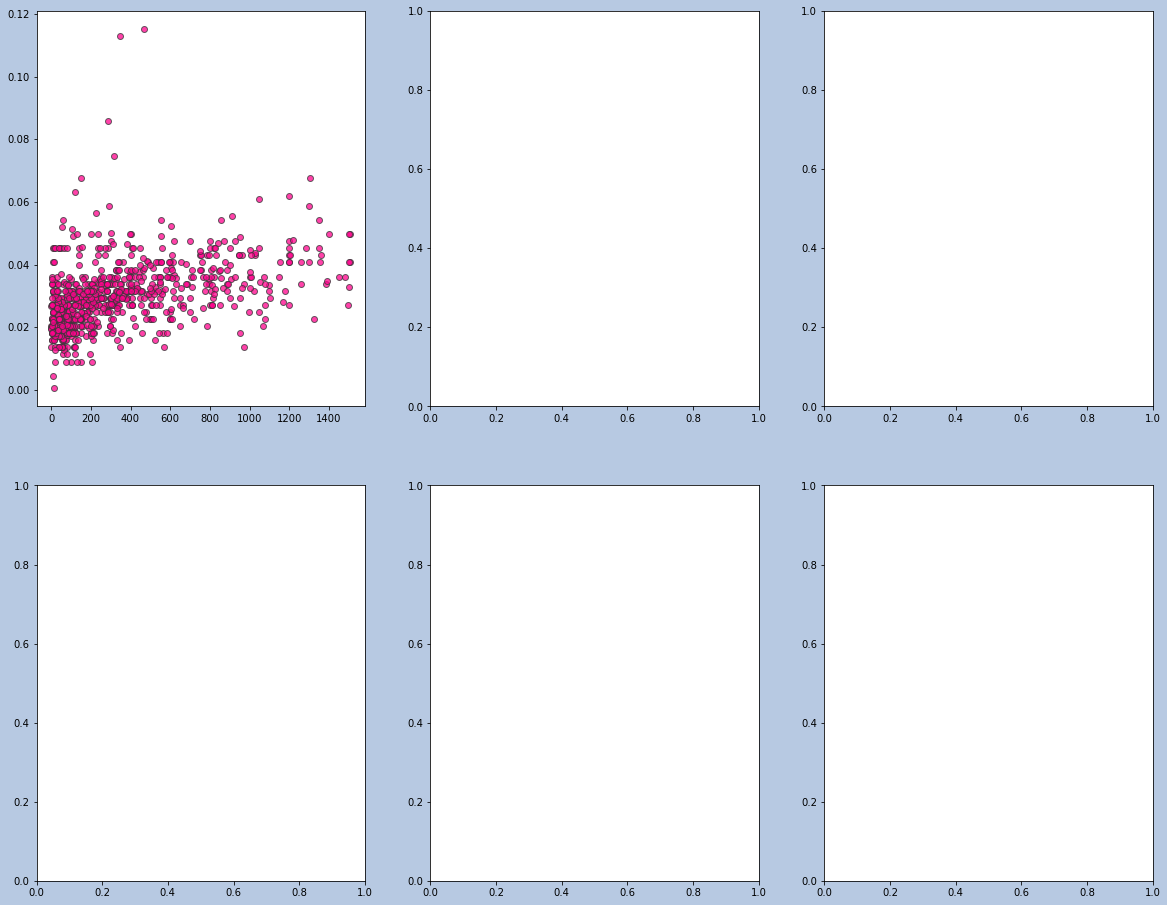

In [1057]:
fig, axs = plt.subplots(2,3,figsize=(20,16),facecolor='xkcd:light blue grey')
for i in range(2):
    for j in range(3):
        axs[i,j].scatter(new_weight,lwstat[i,j],c=colors[i,j],alpha=0.75,edgecolor='xkcd:dark grey')
        m,b,r,p,stderr = stats.linregress(new_weight,lwstat[i,j])
        xax = np.linspace(axs[i,j].get_xlim()[0], axs[i,j].get_xlim()[1],250)
        axs[i,j].plot(xax,m*xax + b,linewidth=3, color="xkcd:chocolate",label=f"Linear Regression resulted in\nan r2-value of {round(r,4)} with\na p-value of {round(p,4)}.")
        axs[i,j].set_xlabel('Pokemon Weight (lbs)')
        axs[i,j].set_ylabel(f'Pokemon {stat_name[i,j]}')
        axs[i,j].set_title(f'Pokemon Weight versus {stat_name[i,j]} \n (Weight Outliers Removed)',fontsize=22, fontweight="bold")
        axs[i,j].set_facecolor('xkcd:pale aqua')
        axs[i,j].legend(loc="upper right",fontsize=18)
plt.tight_layout()
plt.savefig('./assets/plots/weight-stats/lightweight_stats.png',bbox_inches='tight')
plt.close('all')

## Height

In [ ]:
height = pre.normalize(np.reshape(pokestats.height.values,(-1,1)),axis=0)
hp = pre.normalize(np.reshape(pokestats.hp.values,(-1,1)),axis=0)
attack = pre.normalize(np.reshape(pokestats.attack.values,(-1,1)),axis=0)
defense = pre.normalize(np.reshape(pokestats.defense.values,(-1,1)),axis=0)
spattack = pre.normalize(np.reshape(pokestats.special_attack.values,(-1,1)),axis=0)
spdefense = pre.normalize(np.reshape(pokestats.special_defense.values,(-1,1)),axis=0)
speed = pre.normalize(np.reshape(pokestats.speed.values,(-1,1)),axis=0)

## Height Frequency

In [ ]:
fig, ax = plt.subplots(figsize=(10,8),facecolor='xkcd:light blue grey')
ax.hist(height,bins=100,color='xkcd:dark lilac',label='Log-Frequency')
plt.legend(fontsize=18)
ax.set_yscale('log')
ax.set_xlabel('Height',fontsize=16)
ax.set_facecolor('xkcd:pale aqua')
ax.set_title('Log-Tranform Frequency of Pokemon Height',fontsize=22,fontweight="bold")
plt.savefig('./assets/plots/height-stats/height_freq.png',bbox_inches='tight')
plt.close('all')

## Height vs. Stats

In [ ]:
lower, upper = np.quantile(height,.25)-1.5*stats.iqr(height), np.quantile(height,.75)+1.5*stats.iqr(height)
out_height = np.where(np.logical_or(height<=lower,height>=upper))
bad_height = height[out_height]
badh_hp = hp[out_height]
badh_attack = attack[out_height]
badh_defense = defense[out_height]
badh_spattack = sp_attack[out_height]
badh_spdefense = sp_defense[out_height]
badh_speed = speed[out_height]

In [ ]:
short_height = np.where(np.logical_and(height>lower,height<upper))
new_height = height[short_height]
short_hp = hp[short_height]
short_attack = attack[short_height]
short_defense = defense[short_height]
short_spattack = sp_attack[short_height]
short_spdefense = sp_defense[short_height]
short_speed = speed[short_height]

In [ ]:
fig, axs = plt.subplots(2,3,figsize=(20,16),facecolor='xkcd:light blue grey')
shstat = np.array([[short_hp,short_attack,short_defense],[short_spattack,short_spdefense,short_speed]])
badstat = np.array([[badh_hp,badh_attack,badh_defense],[badh_spattack,badh_spdefense,badh_speed]])

for i in range(2):
    for j in range(3):
        axs[i,j].scatter(new_height,shstat[i,j],c=colors[i,j],alpha=0.75,edgecolor='xkcd:dark grey')
        axs[i,j].scatter(bad_height,badstat[i,j],c='xkcd:charcoal grey',label='Outliers',marker="x")
        axs[i,j].set_xlabel('Pokemon Height (ft)')
        axs[i,j].set_ylabel(f'Pokemon {stat_name[i,j]}')
        axs[i,j].set_title(f'Pokemon Height versus {stat_name[i,j]}',fontsize=22, fontweight="bold")
        axs[i,j].set_facecolor('xkcd:pale aqua')
        axs[0,j].legend(loc='lower right',fontsize=20)
        axs[1,j].legend(loc='upper right',fontsize=20)
plt.tight_layout()
plt.savefig('./assets/plots/height-stats/height_stats.png',bbox_inches='tight')
plt.close('all')

## Height Outliers Removed

In [ ]:
fig, ax = plt.subplots(figsize=(10,8),facecolor='xkcd:light blue grey')
ax.hist(new_height,bins=20,color='xkcd:dark lilac',label='Frequency')
plt.legend(fontsize=18)
ax.set_xlabel('Height',fontsize=16)
ax.set_title('Frequency of Pokemon Height \n (Outliers Removed)',fontsize=22,fontweight="bold")
ax.set_facecolor('xkcd:pale aqua')
plt.savefig('./assets/plots/height-stats/shortheight_freq.png',bbox_inches='tight')
plt.close('all')

In [ ]:
fig, axs = plt.subplots(2,3,figsize=(20,16),facecolor='xkcd:light blue grey')
for i in range(2):
    for j in range(3):
        axs[i,j].scatter(new_height,shstat[i,j],c=colors[i,j],alpha=0.75,edgecolor='xkcd:dark grey')
        m,b,r,p,stderr = stats.linregress(new_height,shstat[i,j])
        xax = np.linspace(axs[i,j].get_xlim()[0], axs[i,j].get_xlim()[1],250)
        axs[i,j].plot(xax,m*xax + b,linewidth=3, color="xkcd:chocolate",label=f"Linear Regression resulted in\nan r2-value of {round(r,4)} with\na p-value of {round(p,4)}.")
        axs[i,j].set_xlabel('Pokemon Height (lbs)')
        axs[i,j].set_ylabel(f'Pokemon {stat_name[i,j]}')
        axs[i,j].set_title(f'Pokemon Height versus {stat_name[i,j]} \n (Height Outliers Removed)',fontsize=22, fontweight="bold")
        axs[i,j].set_facecolor('xkcd:pale aqua')  
        axs[i,j].legend(loc="upper right",fontsize=18)
plt.tight_layout()
plt.savefig('./assets/plots/height-stats/shortheight_stats.png',bbox_inches='tight')
plt.close('all')

In [ ]:
pokebasics = pd.DataFrame([pokemon.name,pokemon.pokedex_number,pokemon.abilities,pokemon.typing,pokemon.gen_introduced,pokemon.can_evolve,pokemon.evolves_from,pokemon.number_pokemon_with_typing]).T

In [ ]:
pokecolor = pd.DataFrame([pokemon.name, pokemon.pokedex_number,pokemon.primary_color]).T

In [ ]:
pokecolor.set_index(pokecolor.name,inplace=True)
pokecolor.drop(columns='name', inplace=True)

In [ ]:
pokecolor = pokecolor.merge(pokestats.primary_type,right_index=True,left_index=True)
pokecolor = pokecolor.merge(pokestats.second_type,right_index=True,left_index=True)

In [ ]:
from collections import OrderedDict

keys = list(pokecolor.primary_color.drop_duplicates().values)
colordict = {"White":"xkcd:off white","Brown":"xkcd:milk chocolate","Gray":"xkcd:cool grey","Purple":"xkcd:lighter purple","Yellow":"xkcd:lemon yellow","Black":"xkcd:black","Pink":"xkcd:barbie pink","Blue":"xkcd:deep sky blue","Red":"xkcd:fire engine red","Green":"xkcd:leaf green"}

typecolors = OrderedDict.fromkeys(monotypes)
labels1 = OrderedDict.fromkeys(types1.flatten())
labels2 = OrderedDict.fromkeys(types2.flatten())
labels3 = OrderedDict.fromkeys(types3.flatten())

for t in monotypes:
    poketype = pokecolor[pokecolor.primary_type == t]
    pokecolors = poketype.primary_color
    colorcounts = pokecolors.value_counts()
    colorlist = list(colorcounts.keys())
    typecolors[t] = [colordict[c] for c in colorlist]
    if t in types1.flatten():
        labels1[t] = [f"{colorlist[i]}:\n{colorcounts[i]}" for i in range(len(colorlist))]
    elif t in types2.flatten():
        labels2[t] = [f"{colorlist[i]}:\n{colorcounts[i]}" for i in range(len(colorlist))]
    else: 
        labels3[t] = [f"{colorlist[i]}:\n{colorcounts[i]}" for i in range(len(colorlist))]


In [ ]:
colors = dict.fromkeys(set(pokecolor.primary_color.values))
colortype = dict.fromkeys(monotypes)
fig, axs = plt.subplots(2, 3, figsize=(
    20, 16), facecolor='xkcd:light blue grey',sharey=True)
for i in range(2):
    for j in range(3):
        tcount = pokecolor.primary_color.loc[pokecolor.primary_type == types1[i, j]].value_counts()
        poketotal1 = len(pokecolor.pokedex_number.loc[pokecolor.primary_type == types1[i, j]])
        colortype[types1[i, j]] = tcount.plot.bar(rot=0, color=typecolors[types1[i, j]], ax=axs[i, j], edgecolor='k',
                                                  width=.9, label=f"Total no. of Pokemon\nwith {types1[i,j]} as\nPrimary Type: {poketotal1}")
        colortype[types1[i, j]].set_ylabel("Color Frequency", fontsize=16)
        xlocs = colortype[types1[i, j]].get_xticks()
        for k in range(len(xlocs)):
            colortype[types1[i, j]].text(x=xlocs[k], y=tcount[k],s=labels1[types1[i,j]][k],fontweight="bold",fontsize=12,ha="center",va="bottom")
        colortype[types1[i,j]].set_xticks([])
        colortype[types1[i, j]].set_title(f"Color Distribution for\n{types1[i,j]}-Type Pokemon", fontsize=22, fontweight="bold")
        colortype[types1[i, j]].set_facecolor('xkcd:light peach')
        colortype[types1[i, j]].legend(loc='upper right', fontsize=18)

        
plt.tight_layout()
plt.savefig('./assets/plots/color-count/colorbytype1.png', bbox_inches='tight')
plt.close('all')


In [ ]:
colors = dict.fromkeys(set(pokecolor.primary_color.values))
colortype = dict.fromkeys(monotypes)
fig, axs = plt.subplots(2,3,figsize=(20,16),facecolor='xkcd:light blue grey',sharey=True)
for i in range(2):
    for j in range(3):  
        tcount = pokecolor.primary_color.loc[pokecolor.primary_type==types2[i,j]].value_counts()
        poketotal2 = len(pokecolor.pokedex_number.loc[pokecolor.primary_type==types2[i,j]]) 
        colortype[types2[i,j]] = tcount.plot.bar(rot=0,color=typecolors[types2[i,j]],ax=axs[i,j],edgecolor='k',width=.85,label=f"Total no. of Primarily\n{types2[i,j]}-type Pokemon:\n{poketotal2}")
        colortype[types2[i,j]].set_ylabel("Color Frequency",fontsize=16)
        xlocs = colortype[types2[i, j]].get_xticks()
        for k in range(len(xlocs)):
            colortype[types2[i, j]].text(x=xlocs[k], y=tcount[k],s=labels2[types2[i,j]][k],fontweight="bold",fontsize=12,ha="center",va="bottom")
        colortype[types2[i,j]].set_xticks([])
        colortype[types2[i,j]].set_title(f"Color Distribution for\n{types2[i,j]}-Type Pokemon", fontsize=22,fontweight="bold")
        colortype[types2[i,j]].set_facecolor('xkcd:light peach')
        colortype[types2[i,j]].legend(loc='upper right',fontsize=18)

plt.tight_layout()
plt.savefig('./assets/plots/color-count/colorbytype2.png',bbox_inches='tight')
plt.close('all')

In [ ]:
colors = dict.fromkeys(set(pokecolor.primary_color.values))
colortype = dict.fromkeys(monotypes)
fig, axs = plt.subplots(2,3,figsize=(20,16),facecolor='xkcd:light blue grey',sharey=True)
for i in range(2):
    for j in range(3):
        tcount = pokecolor.primary_color.loc[pokecolor.primary_type==types3[i,j]].value_counts()
        poketotal3 = len(pokecolor.pokedex_number.loc[pokecolor.primary_type==types3[i,j]])
        colortype[types3[i,j]] = tcount.plot.bar(rot=0,color=typecolors[types3[i,j]],ax=axs[i,j],edgecolor='k',width=.85,label=f"Total no. of Primarily\n{types3[i,j]}-type Pokemon:\n{poketotal3}")
        colortype[types3[i,j]].set_ylabel("Color Frequency",fontsize=16)
        xlocs = colortype[types3[i, j]].get_xticks()        
        colortype[types3[i,j]].set_xticks([])
        for k in range(len(xlocs)):
            colortype[types3[i, j]].text(x=xlocs[k], y=tcount[k],s=labels3[types3[i,j]][k],fontweight="bold",fontsize=12,ha="center",va="bottom")
        colortype[types3[i,j]].set_title(f"Color Distribution for\n{types3[i,j]}-Type Pokemon",fontsize=22,fontweight="bold")
        colortype[types3[i,j]].set_facecolor('xkcd:light peach')
        colortype[types3[i,j]].legend(loc='upper right',fontsize=18)


plt.tight_layout()
plt.savefig('./assets/plots/color-count/colorbytype3.png',bbox_inches='tight')
plt.close('all')


In [ ]:
pokegen = pd.DataFrame([pokemon.name, pokemon.pokedex_number, pokemon.gen_introduced,pokemon.legendary,pokemon.mythical,pokemon.hp,pokemon.attack,pokemon.defense,pokemon.special_attack,pokemon.special_defense,pokemon.speed]).T

In [ ]:
pokegen.set_index(pokegen.name,inplace=True)
pokegen.drop(columns='name', inplace=True)

In [ ]:
gengroup = pokegen.groupby('gen_introduced')
legendno = []
for i in range(1,9): 
    len1 = len(gengroup.get_group(i).loc[pokegen.legendary == True])
    len2 = len(gengroup.get_group(i).loc[pokegen.mythical == True])
    legendno.append(len1+len2)

In [ ]:
fig, ax = plt.subplots(figsize=(10,8),facecolor='xkcd:light blue grey')
ax.plot(range(1,9),legendno,color='xkcd:light eggplant',linewidth=5,marker='o',markersize=7)
ax.set_facecolor('xkcd:banana')
ax.set_xlabel('Generation Introduced',fontsize=13)
ax.set_xlim(1,8)
plt.xticks(fontsize=8)
plt.yticks(range(0,22,2),fontsize=8)
ax.set_ylim(0,max(legendno)+1)
plt.grid(True)
ax.set_ylabel('Number of Legendary and Mythical Pokemon',fontsize=13)
ax.set_title('The Number of Legendary and Mythical Pokemon\nIntroduced Each Generation',fontsize=15,fontweight="bold")
plt.savefig('./assets/plots/generation-plots/legendaries.png',bbox_inches='tight')
plt.close('all')

In [ ]:
forms = []
for i in range(1,9):
    forms.append(len(pokemon.groupby('gen_introduced').get_group(i).loc[pokemon.forms_switchable == True]))

In [ ]:
fig, ax = plt.subplots(figsize=(10,8),facecolor='xkcd:light blue grey')
ax.plot(range(1,9),forms,color='xkcd:light eggplant',linewidth=5,marker='o',markersize=7)
ax.grid(True)
ax.set_facecolor('xkcd:banana')
ax.set_xlabel('Generation Introduced',fontsize=13)
ax.set_xlim(1,8)
ax.set_ylim(0,max(forms)+1)
plt.xticks(fontsize=8)
plt.yticks(range(0,36,4),fontsize=8)
ax.set_ylabel('Number of Pokemon with Alternate Forms',fontsize=13)
ax.set_title('The Number of Pokemon\nwith Alternate Forms Introduced Each Generation',fontsize=15,fontweight="bold")
plt.savefig('./assets/plots/generation-plots/forms.png',bbox_inches='tight')
plt.close('all')

In [ ]:
fig, ax = plt.subplots(figsize=(10,8),facecolor='xkcd:light blue grey')
ax.plot(range(1,9),legendno,color='xkcd:light eggplant',linewidth=5,marker='o',markersize=7,label="Legendary Count")
ax.plot(range(1,9),forms,color='xkcd:deep sky blue',linewidth=5,marker='o',markersize=7,label = "Multi-Form Count")
ax.set_facecolor('xkcd:banana')
ax.set_xlabel('Generation Introduced',fontsize=13)
ax.set_xlim(1,8)
plt.xticks(fontsize=8)
plt.yticks(range(0,max(max(forms),max(legendno))+np.gcd(max(forms),max(legendno)),np.gcd(max(forms),max(legendno))),fontsize=8)
ax.set_ylim(0,max(max(forms),max(legendno))+np.gcd(max(forms),max(legendno)))
plt.grid(True)
ax.legend(loc="upper right",fontsize=13)
ax.set_ylabel('Count',fontsize=13)
ax.set_title('Comparing the Counts of\nLegendary and Multi-Form Pokemon',fontsize=15,fontweight="bold")
plt.savefig('./assets/plots/generation-plots/formslegends.png',bbox_inches='tight')
plt.close('all')

In [ ]:
meanstatbygen = {s: [gengroup.get_group(i)[s].mean() for i in range(1,9)] for s in typenorm['Bug']['Stat']}
medstatbygen = {s: [gengroup.get_group(i)[s].median() for i in range(1,9)] for s in typenorm['Bug']['Stat']}

cumgens = dict.fromkeys(range(1,9))
for g in range(1,9):
    cumgens[g] = range(1,g+1)

cumstats = dict.fromkeys(typenorm['Bug']['Stat'])
cumstatsbygen = dict.fromkeys(range(1,9))
allstats = dict.fromkeys(typenorm['Bug']['Stat'])
cummean = dict.fromkeys(typenorm['Bug']['Stat'])
cummed = dict.fromkeys(typenorm['Bug']['Stat'])
for s in typenorm['Bug']['Stat']:
    statlist = [list(gengroup.get_group(i)[s].values) for i in range(1,9)]
    allstats[s] = statlist

for s in typenorm['Bug']['Stat']:
    cumstats[s] = list()
for s in  typenorm['Bug']['Stat']:
    cumstats[s].append(allstats[s][0])
    for i in range(1,8):
        cumstats[s].append(cumstats[s][i-1]+allstats[s][i])

for s in typenorm['Bug']['Stat']:
    cummean[s] = list()
    cummed[s] = list()
    for i in range(8):
        cummean[s].append(np.mean(cumstats[s][i]))
        cummed[s].append(np.median(cumstats[s][i]))

CMean = pd.DataFrame(cummean,index=list(range(1,9)))
CMed = pd.DataFrame(cummed,index=list(range(1,9)))

In [ ]:
CMean

,hp,attack,defense,special_attack,special_defense,speed
1,64.211921,72.913907,68.225166,67.139073,66.086093,69.066225
2,66.908367,71.059761,68.808765,66.087649,68.577689,66.015936
3,66.474093,71.854922,68.800518,66.784974,67.761658,64.476684
4,67.912779,73.669371,70.190669,68.194726,69.219067,65.561866
5,68.489985,75.439137,70.442219,68.446841,68.765794,65.810478
6,68.532594,75.270458,70.780860,68.980583,69.221914,65.797503
7,68.802225,76.504326,71.731768,69.822002,69.889988,65.810878
8,69.042316,76.891982,71.875278,69.976615,69.865256,65.992205


In [ ]:
CMed

,hp,attack,defense,special_attack,special_defense,speed
1,60.0,70.0,65.0,65.0,65.0,70.0
2,65.0,70.0,65.0,65.0,65.0,65.0
3,63.5,70.0,65.0,65.0,65.0,64.0
4,65.0,72.0,65.0,65.0,65.0,65.0
5,65.0,75.0,65.0,65.0,65.0,65.0
6,65.0,75.0,65.0,65.0,65.0,65.0
7,65.0,75.0,67.0,65.0,65.0,65.0
8,65.0,75.0,67.0,65.0,65.0,65.0


In [ ]:
statarray = np.array([['hp','attack','defense'],['special_attack','special_defense','speed']])
colorarray = np.array([['xkcd:fire engine red','xkcd:brick orange', 'xkcd:sunflower yellow'],['xkcd:clear blue', 'xkcd:lawn green', 'xkcd:amethyst']])
compcolors = np.array([['xkcd:pale light green','xkcd:pastel blue', 'xkcd:pastel purple'],['xkcd:pastel orange', 'xkcd:pale pink', 'xkcd:pastel yellow']])

In [ ]:
fig, axs = plt.subplots(2,3,figsize=(20,16),facecolor='xkcd:light blue grey')
for i in range(2):
    for j in range(3):
        axs[i,j].plot(range(1,9),CMean[statarray[i,j]],color=colorarray[i,j],marker='o',markersize=6,label='Cumulative Mean',linewidth=3)
        axs[i,j].plot(range(1,9),CMed[statarray[i,j]],color=colorarray[i,j],linestyle='dashed',marker='o',markersize=6, label='Cumulative Median',linewidth=2)
        axs[i,j].set_facecolor(compcolors[i,j])
        axs[i,j].set_xlabel('Generation',fontsize=14)
        if "special" in statarray[i,j]:
            axs[i,j].set_ylabel(f"Sp. {statarray[i,j].split('_')[1].capitalize()}",fontsize=12)
            axs[i,j].set_title(f"Cumulative Mean vs.\nCumulative Median Pokemon\nSp. {statarray[i,j].split('_')[1].capitalize()} over Generations",fontsize=18, fontweight="bold")
        else:
            axs[i,j].set_ylabel(f"{statarray[i,j].capitalize()}",fontsize=14)
            axs[i,j].set_title(f"Cumulative Mean vs.\nCumulative Median Pokemon\n{statarray[i,j].capitalize()} over Generations",fontsize=18, fontweight="bold")
        axs[i,j].legend(loc="upper left", fontsize=14)
        axs[i,j].grid(color="xkcd:dark grey",alpha=.7)
plt.tight_layout()
plt.savefig('./assets/plots/generation-plots/cumstatsbygen.png',bbox_inches='tight')
plt.close('all')

In [ ]:
fig, axs = plt.subplots(2,3,figsize=(20,16),facecolor='xkcd:light blue grey',sharey=True)
for i in range(2):
    for j in range(3):
        axs[i,j].plot(range(1,9),meanstatbygen[statarray[i,j]],color=colorarray[i,j],marker='o',markersize=6,label='Mean',linewidth=3)
        axs[i,j].plot(range(1,9),medstatbygen[statarray[i,j]],color=colorarray[i,j],linestyle='dashed',marker='o',markersize=6, label='Median',linewidth=2)
        axs[i,j].set_facecolor(compcolors[i,j])
        axs[i,j].set_xlabel('Generation',fontsize=16)
        if "special" in statarray[i,j]:
            axs[i,j].set_ylabel(f"Sp. {statarray[i,j].split('_')[1].capitalize()}",fontsize=22)
            axs[i,j].set_title(f"Mean vs. Median Pokemon\nSp. {statarray[i,j].split('_')[1].capitalize()} by Generation",fontsize=18, fontweight="bold")
        else:
            axs[i,j].set_ylabel(f"{statarray[i,j].capitalize()}",fontsize=22)
            axs[i,j].set_title(f"Mean vs. Median Pokemon\n{statarray[i,j].capitalize()} by Generation",fontsize=18, fontweight="bold")
        axs[i,j].legend(loc="lower right", fontsize=16)
        axs[i,j].grid(color="xkcd:dark grey",alpha=.7)
plt.tight_layout()
plt.savefig('./assets/plots/generation-plots/statsbygen.png',bbox_inches='tight')
plt.close('all')

In [ ]:
pokestats.keys()

Index(['pokedex_number', 'primary_type', 'second_type', 'weight', 'height',
       'hp', 'attack', 'defense', 'special_attack', 'special_defense',
       'speed'],
      dtype='object')

In [ ]:
stat = np.ndarray.flatten(statarray)

def norm(s):
    ma = s.max()
    mi = s.min()
    snew = []
    for x in s:
        normx = (float(x) - mi)/(ma-mi)
        snew.append(normx)
    return snew

def normed():
    norm_dict = dict.fromkeys(pokemon.keys())
    for x in pokemon.keys():
        if x in stat:
            norm_dict[x] = norm(pokemon[x].loc[pokemon.baby_pokemon == False].loc[pokemon.legendary == False])
        else:
            norm_dict[x] = pokemon[x].loc[pokemon.baby_pokemon == False].loc[pokemon.legendary == False]
    newdf = pd.DataFrame(norm_dict)
    return newdf
        
pokenorm = normed()

pokenorm[stat].describe()

,hp,attack,defense,special_attack,special_defense,speed
count,823.000000,823.000000,823.000000,823.000000,823.000000,823.000000
mean,0.261656,0.402125,0.292032,0.341977,0.228103,0.383930
std,0.098606,0.162889,0.126783,0.164665,0.121299,0.176378
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.192913,0.284091,0.200000,0.205882,0.142857,0.254839
50%,0.251969,0.392045,0.266667,0.317647,0.214286,0.367742
75%,0.311024,0.511364,0.355556,0.452941,0.309524,0.509677
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
for s in stat:
    print(s, stats.normaltest(pokenorm[s]))

hp NormaltestResult(statistic=386.11158300064284, pvalue=1.4352747742259733e-84)
attack NormaltestResult(statistic=19.61138602115866, pvalue=5.513680979055247e-05)
defense NormaltestResult(statistic=183.62750970023092, pvalue=1.3359583101451221e-40)
special_attack NormaltestResult(statistic=45.12280703825541, pvalue=1.5911347020802094e-10)
special_defense NormaltestResult(statistic=120.62770132128529, pvalue=6.397753097430156e-27)
speed NormaltestResult(statistic=25.14744997897433, pvalue=3.4617892112026933e-06)


# These stats are VERY MUCH NOT normally distributed!

In [ ]:
def norm2(s):
    mu = s.mean()
    sig = s.std()
    snew = []
    for x in s:
        normx = (float(x) - mu)/sig
        snew.append(normx)
    return snew

def normed2():
    norm_dict = dict.fromkeys(pokemon.keys())
    for x in pokemon.keys():
        if x in stat:
            norm_dict[x] = norm2(pokemon[x])
        else:
            norm_dict[x] = pokemon[x]
    newdf = pd.DataFrame(norm_dict)
    return newdf

pokestandard = normed2()
pokestandard[stat].describe()


,hp,attack,defense,special_attack,special_defense,speed
count,8.980000e+02,8.980000e+02,8.980000e+02,8.980000e+02,8.980000e+02,8.980000e+02
mean,4.267806e-16,1.871647e-16,2.855919e-16,-6.354729e-17,1.541702e-16,1.565192e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.595847e+00,-2.399236e+00,-2.262249e+00,-2.024516e+00,-1.841538e+00,-2.138867e+00
25%,-7.264735e-01,-7.305964e-01,-7.399942e-01,-7.755776e-01,-7.336297e-01,-7.361521e-01
50%,-1.542163e-01,-6.314071e-02,-1.649203e-01,-1.679860e-01,-1.796753e-01,-3.479452e-02
75%,4.180409e-01,6.960901e-01,6.131209e-01,6.758911e-01,5.589305e-01,6.665630e-01
max,7.094375e+00,3.474374e+00,5.349024e+00,3.713849e+00,5.913823e+00,4.699369e+00


In [ ]:
for x in stat:
    print(stats.normaltest(pokestandard[x]))

NormaltestResult(statistic=362.44100517354707, pvalue=1.981233756020955e-79)
NormaltestResult(statistic=18.521130127423717, pvalue=9.510157151205618e-05)
NormaltestResult(statistic=165.98573829505503, pvalue=9.05013154759617e-37)
NormaltestResult(statistic=46.88755198917057, pvalue=6.584115648807457e-11)
NormaltestResult(statistic=128.486236269012, pvalue=1.2576746113887108e-28)
NormaltestResult(statistic=27.68991554483248, pvalue=9.709821301123567e-07)


# Not even normalization can fix this!

## Let's plot!

In [ ]:
from pylab import rcParams
fig, axs = plt.subplots(2,3,figsize=(20,16),facecolor="xkcd:light blue grey",sharey=True)
kd = [[],[]]
for i in range(0,4):
    kd[0].append(stats.gaussian_kde(pokenorm[stat[i]].values))
for i in range(0,4):
    kd[1].append(stats.gaussian_kde(pokenorm[stat[i]].values))
kd = np.array(kd)
yl = "Estimated Density"
for i in range(2):
    for j in range(3):
        axs[i,j].hist(pokenorm[statarray[i,j]],bins = 'auto',density=True, label = f"{statarray[i,j].capitalize()} Density Histogram)",color=compcolors[i,j])
        x = np.linspace(0,1,10**4)
        axs[i,j].plot(x,kd[i,j](x),label=f"Kernel Density Estimation\nfor {statarray[i,j]}",color=colorarray[i,j],linewidth=4)
        axs[i,j].set_ylabel(yl,fontsize=18)
        axs[i,j].set_xlabel(f"{statarray[i,j].capitalize()}",fontsize=25)
        axs[i,j].legend(loc='upper right')
        axs[i,j].set_facecolor(color="#777777")

axs[1,1].set_title(f"\nThe Density Histograms\nFor Each Pokemon Stat After Normalization",{'fontsize': 22,
 'fontweight' : "bold",
 'verticalalignment': 'bottom',
 'horizontalalignment': 'center'},fontsize = 50,pad=50)
plt.tight_layout()
plt.savefig('./assets/plots/stats-general/statdensity.png',bbox_inches='tight')
plt.close('all')


In [ ]:
names = ['hp', 'attack', 'defense', 'special_attack', 'special_defense', 'speed']
name_dict = {'h':'hp', 'a':'attack','d': 'defense', 'spa':'special_attack', 'spd':'special_defense','s':'speed'}
mix = []
for x in names:
    for y in names:
        if x != y:
            mix.append((x,y))
        else:
            mix.append((x))

In [ ]:
mixnames=[]
for x in names:
    mixnames.append([(x,y) for y in names])

In [ ]:
namearray = np.array(mixnames)
namearray

array([[['hp', 'hp'],
        ['hp', 'attack'],
        ['hp', 'defense'],
        ['hp', 'special_attack'],
        ['hp', 'special_defense'],
        ['hp', 'speed']],

       [['attack', 'hp'],
        ['attack', 'attack'],
        ['attack', 'defense'],
        ['attack', 'special_attack'],
        ['attack', 'special_defense'],
        ['attack', 'speed']],

       [['defense', 'hp'],
        ['defense', 'attack'],
        ['defense', 'defense'],
        ['defense', 'special_attack'],
        ['defense', 'special_defense'],
        ['defense', 'speed']],

       [['special_attack', 'hp'],
        ['special_attack', 'attack'],
        ['special_attack', 'defense'],
        ['special_attack', 'special_attack'],
        ['special_attack', 'special_defense'],
        ['special_attack', 'speed']],

       [['special_defense', 'hp'],
        ['special_defense', 'attack'],
        ['special_defense', 'defense'],
        ['special_defense', 'special_attack'],
        ['special_defense', '

In [ ]:
# cmaps = np.array([[colorarray[0,0],'OrRd','YlOrRd','gist_stern','CMRmap','RdPu'],['OrRd',colorarray[0,1],'Wistia','viridis','plasma','inferno'],['YlOrRd','Wistia',colorarray[0,2],'YlGn','YlGnBu','gnuplot'],['gist_stern','viridis','YlGn',colorarray[1,0],'GnBu','cubehelix'],['CMRmap','plasma','YlGnBu','BuGn',colorarray[1,1],'BuPu'],['PuRd','inferno','gnuplot','cubehelix','PuBu',colorarray[1,2]]])
cmaps = [[],[],[],[],[],[]]
fc = [[],[],[],[],[],[]]
for i in range(6):
    for j in range(i+1):
        cmaps[i].append("plasma")
        fc[i].append("#dddddd")
    for j in range(5-i):
        cmaps[i].append("plasma_r")
        fc[i].append("#333333")
# 0-1, ..., 0-5
# 1-2,...,1-5
# 2-3,...,2-5
# 3-4,...,3-5
# 4-5

In [ ]:
plasma= [(254,188,43),(244,136,73),(219,92,104),(185,50,137),(139,10,165),(84,2,163)]
colorplasma = ['#%02x%02x%02x' % x for x in plasma]

In [ ]:
for i in range(6):
    cmaps[i][i] = cmaps[i][i].replace(cmaps[i][i],colorplasma[5-i])
    fc[i][i] = fc[i][i].replace(fc[i][i],["#dddddd", "#bbbbbb", "#999999", "#777777", "#555555", "#333333"][i])
cfinal1 = np.array(cmaps)
fcfinal = np.array(fc)

In [ ]:
for i in range(6):
    cmaps[i][i] = cmaps[i][i].replace(cmaps[i][i],colorplasma[i])
cfinal2 = np.array(cmaps)

In [ ]:
fig,axs = plt.subplots(6,6,facecolor='xkcd:light blue grey',figsize=(20,16))

for i in range(6):
    for j in range(6):
        if i != j:
            x,y = pokenorm[namearray[i,j][0]].values, pokenorm[namearray[i,j][1]].values
            xy = np.vstack([x,y])
            z = stats.gaussian_kde(xy)(xy)
            idx = z.argsort()
            x, y, z = x[idx], y[idx], z[idx] 
            axs[i,j].scatter(x,y,c=z,cmap=cfinal2[i,j])
            m, b, r, p, se = stats.linregress(x,y)
            axs[i,j].plot(x,m*x+b,color='xkcd:vivid green',linewidth=3, label=f'r2 score: {round(r2_score(y,m*x+b),2)}')
            axs[i,j].legend(loc="upper right",fontsize=11)
            axs[i,j].set_yticklabels([])
            axs[i,j].set_facecolor(color=fcfinal[i,j])
            N0, N1 = namearray[i,j][0].capitalize(), namearray[i,j][1].capitalize()
            if "Special" in N0 and "Special" in N1:
                AD0, AD1 = N0.split('_')[1].capitalize(), N1.split('_')[1].capitalize()
                axs[i,j].set_ylabel(f"Sp. {AD1}")
                axs[i,j].set_xlabel(f"Sp. {AD0}")
                axs[i,j].set_title(f"Sp. {AD0} vs. Sp. {AD1}",fontsize=14,fontweight="bold")
            elif "Special" in N0 and "Special" not in N1:
                AD0 = N0.split('_')[1].capitalize()
                axs[i,j].set_ylabel(N1)
                axs[i,j].set_xlabel(f"Sp. {AD0}")
                axs[i,j].set_title(f"Sp. {AD0} vs. {N1}",fontsize=14,fontweight="bold")
            elif "Special" not in N0 and "Special" in N1:
                AD1 = N1.split('_')[1].capitalize()
                axs[i,j].set_ylabel(f"Sp. {AD1}")
                axs[i,j].set_xlabel(N0)
                axs[i,j].set_title(f"{N0} vs. Sp. {AD1}",fontsize=14,fontweight="bold")
            else: 
                axs[i,j].set_ylabel(N1)
                axs[i,j].set_xlabel(N0)
                axs[i,j].set_title(f"{N0} vs. {N1}",fontsize=14,fontweight="bold")
        else:
            x = pokenorm[namearray[i,j][0]].values
            t = np.linspace(0,1,5000)
            kd = stats.gaussian_kde(x)(t)
            axs[i,j].plot(t,kd,color=cfinal1[i,j],linewidth=3)
            axs[i,j].hist(x, bins='auto', density=True, color=cfinal2[i,j])
            axs[i,j].set_ylabel("")
            axs[i,j].set_xlabel("")
            axs[i,j].set_facecolor(color=fcfinal[i,j])
            N = namearray[i,j][0].capitalize()
            if "special" in namearray[i,j][0]:
                axs[i,j].set_title(f"Sp. {N.split('_')[1].capitalize()} Density",fontsize=14,fontweight="bold")
            else:
                axs[i,j].set_title(f"{namearray[i,j][0].capitalize()} Density",fontsize=14,fontweight="bold")
        axs[i,j].grid(False)

fig.colorbar(plt.cm.ScalarMappable(cmap='plasma'),orientation="horizontal",ax=axs[5,0])
fig.colorbar(plt.cm.ScalarMappable(cmap='plasma_r'),orientation="horizontal",ax=axs[0,5])
plt.tight_layout()
plt.savefig("./assets/plots/stats-general/statscatters.png",bbox_inches='tight')

plt.close('all')

In [1058]:
pokemon.set_index(pokemon.pokedex_number,inplace=True)
pokemon.drop(columns="pokedex_number",inplace=True)

In [1059]:
pokemon

,name,abilities,typing,hp,attack,defense,special_attack,special_defense,speed,height,...,base_experience,capture_rate,egg_groups,egg_cycles,base_happiness,can_evolve,evolves_from,primary_color,shape,number_pokemon_with_typing
pokedex_number,,,,,,,,,,,,,,,,,,,,,
1,Bulbasaur,Overgrow~Chlorophyll,Grass~Poison,45,49,49,65,65,45,7,...,64,45,Monster~Grass,20.0,70,True,NaN,Green,Quadruped,15.0
2,Ivysaur,Overgrow~Chlorophyll,Grass~Poison,60,62,63,80,80,60,10,...,142,45,Monster~Grass,20.0,70,True,Bulbasaur,Green,Quadruped,15.0
3,Venusaur,Overgrow~Chlorophyll,Grass~Poison,80,82,83,100,100,80,20,...,236,45,Monster~Grass,20.0,70,False,Ivysaur,Green,Quadruped,15.0
4,Charmander,Blaze~Solar Power,Fire,39,52,43,60,50,65,6,...,62,45,Monster~Dragon,20.0,70,True,NaN,Red,Upright,34.0
5,Charmeleon,Blaze~Solar Power,Fire,58,64,58,80,65,80,11,...,142,45,Monster~Dragon,20.0,70,True,Charmander,Red,Upright,34.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
894,Regieleki,Transistor,Electric,80,100,50,100,50,200,12,...,290,3,Undiscovered,120.0,35,False,NaN,Yellow,Humanoid,34.0
895,Regidrago,Dragons Maw,Dragon,200,100,50,100,50,80,21,...,290,3,Undiscovered,120.0,35,False,NaN,Green,Humanoid,13.0
896,Glastrier,Chilling Neigh,Ice,100,145,130,65,110,30,22,...,290,3,Undiscovered,120.0,35,False,NaN,White,Quadruped,20.0
